# Moment Curvature Example
This example is based on https://opensees.berkeley.edu/wiki/index.php/Moment_Curvature_Example and https://openseespydoc.readthedocs.io/en/latest/src/MomentCurvature.html but using the Reinforcing Steel Material (A706 Grade 60) develop by Moehle https://opensees.berkeley.edu/wiki/index.php/Reinforcing_Steel_Material

For your own moment-curvature analyses take into account that the cover should be outsude of the diameter of the rebar including the transverse reinforcement. In this way the example in the OpenSees wiki doesn't represent a realistic scenario.

The properties of the material A706 grade 60 are the following (Final Report - Performance Characterization of Beams with High-Strength Reinforcement https://pdfs.semanticscholar.org/d74a/710b727f26a06c72ac8729d904fba95fb75e.pdf):

Steel: Uniaxial material ReinforcingSteel (Kunnath et al. 2009) based on Chang and Mander (1994)

| **Model** |**Variable**|**Description**|**Value**|
|:--:|---:|-----:|:----:|
|**ReinforcingSteel**|  |  |  |
| |$f_y$|Yield stress (ksi)|$64.5$|
| |$f_u$|Ultimate stress (ksi)|$95.5$|
| |$E_s$|Young’s modulus (ksi)|$29000$|
| |$E_{sh}$|Tangent stiffness at initiation of strain hardening (ksi)|$950$|
| |$\varepsilon_{sh}$|Strain at initiation of strain hardening|$0.0055$|
| |$\varepsilon_{su}$|Strain at ultimate stress|$0.15$|
| |$l_{RS},$ $\beta,$ $r,$ $\gamma,$|Parameters for buckling model based on Gomes and Appleton (1997)|$5, 1.0, 0.75, 0.0$|
| |$a_1$, $limit$|Parameters for controlling isotropic hardening|$4.3, 0.01$|
| |$R1,$ $R2,$ $R3$|Parameters for controlling transition from elastic to plastic branches|$0.333, 20, 6$|

In [1]:
from openseespy.opensees import *
import numpy as np
import matplotlib.pyplot as plt

## Example 1: ReinforcingSteel

Using the properties of the [table](#Moment-Curvature-Example) I'll try to replicate the section of the [OpenSees example](#Moment-Curvature-Example).

In [2]:
def MomentCurvature(secTag, axialLoad, maxK, numIncr=100):
    
    # Define two nodes at (0,0)
    node(1, 0.0, 0.0)
    node(2, 0.0, 0.0)

    # Fix all degrees of freedom except axial and bending
    fix(1, 1, 1, 1)
    fix(2, 0, 1, 0)
    
    # Define element
    #                             tag ndI ndJ  secTag
    element('zeroLengthSection',  1,   1,   2,  secTag)

    # Define constant axial load
    timeSeries('Constant', 1)
    pattern('Plain', 1, 1)
    load(2, axialLoad, 0.0, 0.0)

    # Define analysis parameters
    integrator('LoadControl', 0.0)
    system('SparseGeneral', '-piv')
    test('NormUnbalance', 1e-9, 500)
    numberer('Plain')
    constraints('Plain')
    #algorithm('Newton')
    algorithm('ModifiedNewton', 'False', 'False')
    analysis('Static')

    # Do one analysis for constant axial load
    analyze(1)

    # Define reference moment
    timeSeries('Linear', 2)
    pattern('Plain',2, 2)
    load(2, 0.0, 0.0, 1.0)

    # Compute curvature increment
    dK = maxK / numIncr

    # Use displacement control at node 2 for section analysis
    integrator('DisplacementControl', 2,3,dK,1,dK,dK)
    
    # Create recorder
    #recorder Node -file section$secTag.out -time -node 2 -dof 3 disp
    import os
    recorder('Node', '-file', 'node2.txt','-time', '-closeOnWrite', '-node', *[2],'-dof', *[3], 'disp')
    recorder('Element', '-file', 'node13.txt', '-closeOnWrite', '-ele', *[1],*['section',1,str(10.5),str(0),"1","stressStrain"])
    recorder('Element', '-file', 'node14.txt', '-closeOnWrite', '-ele', *[1],*['section',1,str(10.5),str(0),"2","stressStrain"])
    # Do the section analysis
    analyze(numIncr)
          
wipe()
print("Start MomentCurvature.py example")

# Define model builder
# --------------------
model('basic','-ndm',2,'-ndf',3)

# Define materials for nonlinear columns
# ------------------------------------------
# CONCRETE                  tag   f'c        ec0   f'cu        ecu
# Core concrete (confined)
uniaxialMaterial('Concrete01',1, -6.0,  -0.0033,  -5.0,  -0.014)

# Cover concrete (unconfined)
uniaxialMaterial('Concrete01',2, -5.0,  -0.002,  0.0,  -0.006)

# STEEL
# Reinforcing steel 
fy = 64.5;      # Yield stress
fu=95.5;
Es = 29000.0;    # Young's modulus
Esh=950;
esh=0.0055;
eult=0.15;
lsr=2;
beta=1;
r=1;
gamma=0;
a1=4.3;
limit=0.01
R1=0.333;
R2=20;
R3=6

#                        tag  fy E0    b
#uniaxialMaterial('Steel01', 3, fy, Es, 1/100)
uniaxialMaterial('ReinforcingSteel', 3, fy, fu, Es, Esh, esh, eult, '-GABuck', lsr, beta, r, gamma, '-IsoHard', a1, limit, '-MPCurveParams', R1, R2, R3)
#uniaxialMaterial('ReinforcingSteel', 3, fy, fu, Es, Esh, esh, eult)
#uniaxialMaterial('ReinforcingSteel', 3, fy, fu, Es, Esh, esh, eult, '-IsoHard', a1, limit, '-MPCurveParams', R1, R2, R3)
#uniaxialMaterial('Steel02', 3, fy, Es, 0.01,*[15,0.925,0.15])

# Define cross-section for nonlinear columns
# ------------------------------------------

# set some paramaters
colWidth = 15
colDepth = 24

cover = 1.5
As = 0.60;     # area of no. 7 bars

# some variables derived from the parameters
y1 = colDepth/2.0
z1 = colWidth/2.0

section('Fiber', 1)

# Create the concrete core fibers
patch('rect',1,20*2,2*2 ,cover-y1, cover-z1, y1-cover, z1-cover)

# Create the concrete cover fibers (top, bottom, left, right)
patch('rect',2,20*2,2*2 ,-y1, z1-cover, y1, z1)
patch('rect',2,20*2,2*2 ,-y1, -z1, y1, cover-z1)
patch('rect',2,4*2,2*2 ,-y1, cover-z1, cover-y1, z1-cover)
patch('rect',2,4*2,2*2 ,y1-cover, cover-z1, y1, z1-cover)

# Create the reinforcing fibers (left, middle, right)
layer('straight', 3, 3, As, y1-cover, z1-cover, y1-cover, cover-z1)
layer('straight', 3, 2, As, 0.0     , z1-cover, 0.0      , cover-z1)
layer('straight', 3, 3, As, cover-y1, z1-cover, cover-y1, cover-z1)

# Estimate yield curvature
# (Assuming no axial load and only top and bottom steel)
# d -- from cover to rebar
d = colDepth-cover
# steel yield strain
epsy = fy/Es
Ky = epsy/(0.75*d)

# Print estimate to standard output
print("Estimated yield curvature: ", Ky)

# Set axial load 
P = -180

# Target ductility for analysis
mu = 25.5

# Number of analysis increments
numIncr = 100

# Call the section analysis procedure
MomentCurvature(1, P, Ky*mu, numIncr)

results = open('results.out','a+')

u = nodeDisp(2,3)
print("Estimated ultimate curvature: ", u)
#if abs(u-0.00190476190476190541)<1e-12:
#    results.write('PASSED : MomentCurvature.py\n');
#    print("Passed!")
#else:
#    results.write('FAILED : MomentCurvature.py\n');
#    print("Failed!")

results.close()

print("==========================")

Start MomentCurvature.py example
Estimated yield curvature:  0.0001318007662835249
Estimated ultimate curvature:  0.0033609195402298894


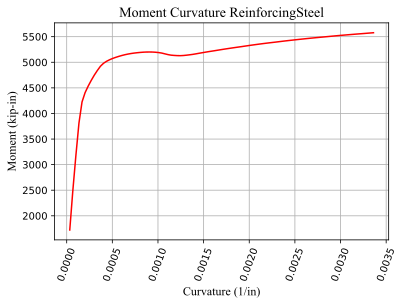

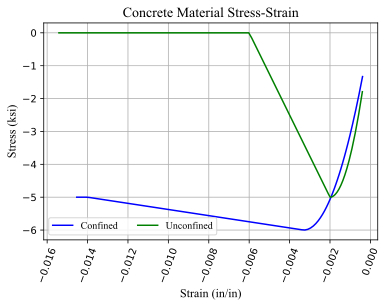

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='Times New Roman',
                                   size=10)

with open('node2.txt', 'r') as f:
    lines = f.readlines()
    y11 = [float(line.split()[0]) for line in lines]
    x11 = [float(line.split()[1]) for line in lines]
plt.plot(x11 ,y11,color='red',label='ReinforcingSteel')
plt.title('Moment Curvature ReinforcingSteel', fontsize=14,fontfamily='Times New Roman',weight='bold')
plt.xlabel('Curvature (1/in)', fontsize=12,fontfamily='Times New Roman',weight='bold')
plt.ylabel('Moment (kip-in)', fontsize=12,fontfamily='Times New Roman',weight='bold')
plt.xticks(rotation=70)
plt.grid(True)
plt.show()

with open('node13.txt', 'r') as f:
    lines = f.readlines()
    y13 = [float(line.split()[0]) for line in lines]
    x13 = [float(line.split()[1]) for line in lines]
plt.plot(x13 ,y13,color='blue',label='Confined')

with open('node14.txt', 'r') as f:
    lines = f.readlines()
    y14 = [float(line.split()[0]) for line in lines]
    x14 = [float(line.split()[1]) for line in lines]
plt.plot(x14 ,y14,color='green',label='Unconfined')

plt.xlabel('Strain (in/in)', fontsize=12,fontfamily='Times New Roman',weight='bold')
plt.ylabel('Stress (ksi)', fontsize=12,fontfamily='Times New Roman',weight='bold')
plt.title('Concrete Material Stress-Strain', fontsize=14,fontfamily='Times New Roman',weight='bold')
legend = plt.legend(loc='best', shadow=False, fontsize='8',ncol=3,prop=font)

plt.xticks(rotation=70)
plt.grid(True)
plt.show()


Now using the same method but using a bilinear steel material the same method as XTRACT

## Example 2: Steel02

Now we will use a bilinear steel material similar in how XTRACT does it

In [4]:
wipe()
print("Start MomentCurvature.py example")

# Define model builder
# --------------------
model('basic','-ndm',2,'-ndf',3)

# Define materials for nonlinear columns
# ------------------------------------------
# CONCRETE                  tag   f'c        ec0   f'cu        ecu
# Core concrete (confined)
uniaxialMaterial('Concrete01',1, -6.0,  -0.0033,  -5.0,  -0.014)

# Cover concrete (unconfined)
uniaxialMaterial('Concrete01',2, -5.0,  -0.002,  0.0,  -0.006)

#                        tag  fy E0    b
#uniaxialMaterial('Steel01', 3, fy, Es, 1/100)
#uniaxialMaterial('ReinforcingSteel', 3, fy, fu, Es, Esh, esh, eult, '-GABuck', lsr, beta, r, gamma, '-IsoHard', a1, limit, '-MPCurveParams', R1, R2, R3)
#uniaxialMaterial('ReinforcingSteel', 3, fy, fu, Es, Esh, esh, eult)
#uniaxialMaterial('ReinforcingSteel', 3, fy, fu, Es, Esh, esh, eult, '-IsoHard', a1, limit, '-MPCurveParams', R1, R2, R3)
uniaxialMaterial('Steel02', 3, fy, Es, 0.01,*[15,0.925,0.15])

# Define cross-section for nonlinear columns
# ------------------------------------------

section('Fiber', 1)

# Create the concrete core fibers
patch('rect',1,20*2,2*2 ,cover-y1, cover-z1, y1-cover, z1-cover)

# Create the concrete cover fibers (top, bottom, left, right)
patch('rect',2,20*2,2*2 ,-y1, z1-cover, y1, z1)
patch('rect',2,20*2,2*2 ,-y1, -z1, y1, cover-z1)
patch('rect',2,4*2,2*2 ,-y1, cover-z1, cover-y1, z1-cover)
patch('rect',2,4*2,2*2 ,y1-cover, cover-z1, y1, z1-cover)

# Create the reinforcing fibers (left, middle, right)
layer('straight', 3, 3, As, y1-cover, z1-cover, y1-cover, cover-z1)
layer('straight', 3, 2, As, 0.0     , z1-cover, 0.0      , cover-z1)
layer('straight', 3, 3, As, cover-y1, z1-cover, cover-y1, cover-z1)

# Estimate yield curvature
# (Assuming no axial load and only top and bottom steel)
# d -- from cover to rebar
d = colDepth-cover
# steel yield strain
epsy = fy/Es
Ky = epsy/(0.75*d)

# Print estimate to standard output
print("Estimated yield curvature: ", Ky)


# Number of analysis increments
numIncr = 100

# Call the section analysis procedure
MomentCurvature(1, P, Ky*mu, numIncr)

results = open('results.out','a+')

u = nodeDisp(2,3)
print("Estimated ultimate curvature: ", u)
#if abs(u-0.00190476190476190541)<1e-12:
#    results.write('PASSED : MomentCurvature.py\n');
#    print("Passed!")
#else:
#    results.write('FAILED : MomentCurvature.py\n');
#    print("Failed!")

results.close()

print("==========================")

Start MomentCurvature.py example
Estimated yield curvature:  0.0001318007662835249
Estimated ultimate curvature:  0.0033609195402298894


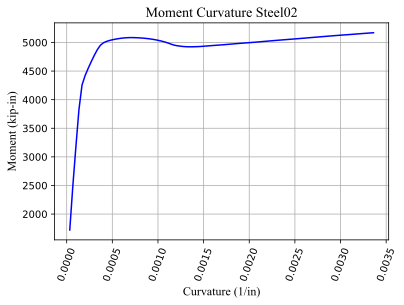

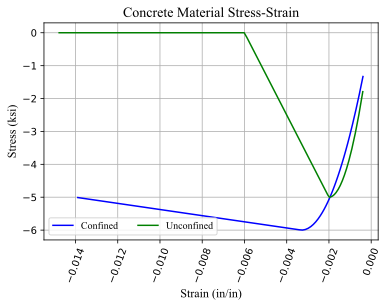

In [5]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
with open('node2.txt', 'r') as f:
    lines = f.readlines()
    y22 = [float(line.split()[0]) for line in lines]
    x22 = [float(line.split()[1]) for line in lines]
plt.plot(x22 ,y22,color='blue',label='Steel02')
plt.title('Moment Curvature Steel02', fontsize=14,fontfamily='Times New Roman',weight='bold')
plt.xlabel('Curvature (1/in)', fontsize=12,fontfamily='Times New Roman',weight='bold')
plt.ylabel('Moment (kip-in)', fontsize=12,fontfamily='Times New Roman',weight='bold')
plt.xticks(rotation=70)
plt.grid(True)
plt.show()

plt.show()

with open('node13.txt', 'r') as f:
    lines = f.readlines()
    y13 = [float(line.split()[0]) for line in lines]
    x13 = [float(line.split()[1]) for line in lines]
plt.plot(x13 ,y13,color='blue',label='Confined')

with open('node14.txt', 'r') as f:
    lines = f.readlines()
    y14 = [float(line.split()[0]) for line in lines]
    x14 = [float(line.split()[1]) for line in lines]
plt.plot(x14 ,y14,color='green',label='Unconfined')

plt.xlabel('Strain (in/in)', fontsize=12,fontfamily='Times New Roman',weight='bold')
plt.ylabel('Stress (ksi)', fontsize=12,fontfamily='Times New Roman',weight='bold')
plt.title('Concrete Material Stress-Strain', fontsize=14,fontfamily='Times New Roman',weight='bold')
legend = plt.legend(loc='best', shadow=False, fontsize='8',ncol=3,prop=font)

plt.xticks(rotation=70)
plt.grid(True)
plt.show()


## XTRACT Comparison

Now we will compare results

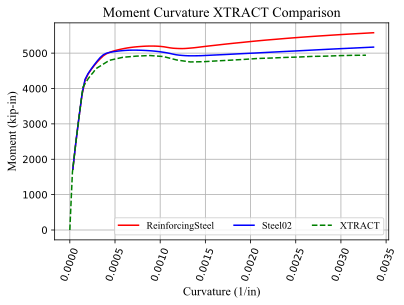

In [6]:
with open('pm.txt', 'r') as f:
    lines = f.readlines()
    y33 = [float(line.split()[0]) for line in lines]
    x33 = [float(line.split()[1]) for line in lines]


x=[x11,x22,x33]
y=[y11,y22,y33]

plt.plot(x[0] ,y[0],color='red',label='ReinforcingSteel')
plt.plot(x[1] ,y[1],color='blue',label='Steel02')
plt.plot(x[2] ,y[2],linestyle='dashed',color='green',label='XTRACT')
plt.title('Moment Curvature XTRACT Comparison', fontsize=14,fontfamily='Times New Roman',weight='bold')
plt.xlabel('Curvature (1/in)', fontsize=12,fontfamily='Times New Roman',weight='bold')
plt.ylabel('Moment (kip-in)', fontsize=12,fontfamily='Times New Roman',weight='bold')
plt.xticks(rotation=70)
plt.grid(True)
legend = plt.legend(loc='best', shadow=False, fontsize='8',ncol=3,prop=font)
plt.show()

# Conclusions

  * The Steel02 steel material can replicate the results of XTRACT accurately because both use the same material stress-strain curve.
  * OpenSees it is faster than XTRACT but the lack of graphical interface it is a big disavantage, also Opensees needs to be checked for maximum concrete strain otherwise it can give unaccurate results. This check needs to be programed manually.
  * OpenSees is a good alternative as long as the results are validated using XTRACT and maximum strains checked.